# Videos analysis

In [1]:
# import libraries
import pandas as pd
from transformers import pipeline
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import math

d:\Documentos\camilo\Maestria\TESIS\tiktok_analytics\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the pre-trained model for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use cpu


In [3]:
# Feature to rate sentiment with Hugging Face
def classify_feeling_comments(row) -> dict:
    
    # Use the Hugging Face pre-trained model
    try:
        result = sentiment_analyzer(row['text'])
    except Exception as e:
        print(f"Error processing row: {row['text']} - {e}")
        return {'score': None, 'clasification': '#ERROR', 'percentage': None, 'date': None, 'video_id': row['video_id']}
    
    # Get the label and score
    label = result[0]['label']
    percentage = result[0]['score']
    parsed_date = datetime.strptime(row['date'], "%d-%m-%Y %H:%M")
    
    # Classification according to the label
    if label == '5 stars':
        clasification = 'Excellent'
        score = 5
    elif label == '4 stars':
        clasification = 'Good'
        score = 4
    elif label == '3 stars':
        clasification = 'Neutral'
        score = 3
    elif label == '2 stars':
        clasification = 'Bad'
        score = 2
    elif label == '1 star':
        clasification = 'Terrible'
        score = 1
    elif label == '0 stars':
        clasification = 'Terrible'
        score = 0
    else:
        clasification = '#ERROR'
        score = None
    
    return {'score': score, 'clasification': clasification, 'percentage': percentage, 'date': parsed_date, 'video_id': row['video_id']}


In [6]:
res = classify_feeling_comments({
    'text': 'Koba is the best dog ever!, I love him so much!, becuase he is so cute! and he is so smart!',
    'date': '01-01-2023 12:00',
    'video_id': '12345'
})
print(res)

{'score': 5, 'clasification': 'Excellent', 'percentage': 0.964150607585907, 'date': datetime.datetime(2023, 1, 1, 12, 0), 'video_id': '12345'}


In [4]:
def process_dataframe_in_parallel(df, process_func, num_partitions=3):
    """
    Process a large dataframe in parallel using threads.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to process
    process_func : function
        The function to apply to each partition (should take a dataframe and return a dataframe)
    num_partitions : int
        Number of partitions to split the dataframe into
        
    Returns:
    --------
    pandas.DataFrame
        The concatenated result of processing all partitions
    """
    # Calculate partition size
    partition_size = math.ceil(len(df) / num_partitions)
    
    # Function to process a partition
    def process_partition(partition_df):
        return partition_df.apply(process_func, axis=1)
    
    # Split dataframe into partitions
    partitions = [df.iloc[i:i + partition_size] for i in range(0, len(df), partition_size)]
    
    # Process partitions in parallel
    results = []
    with ThreadPoolExecutor(max_workers=num_partitions) as executor:
        # Submit all partitions to the executor
        future_results = [executor.submit(process_partition, partition) for partition in partitions]
        
        # Collect results as they complete
        for future in future_results:
            results.append(future.result())
    
    # Concatenate results
    return pd.concat(results)

In [5]:
# Load the Excel file into a DataFrame
df_comments_raw = pd.read_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\output\video_info_03-28-2025_0811_Galan_V2.xlsx",sheet_name='comments_data', dtype=str)


In [41]:
df_comments = df_comments_raw.drop_duplicates(subset=['text']).dropna()

In [42]:
len(df_comments.index)

101317

### Analysis for comments

In [8]:
display(df_comments.head())

,video_id,language,text,likes,date
0,7374919036544601349,es,y la inseguridad que ...? se fijó solo en obra...,53,30-05-2024 21:24
1,7374919036544601349,es,"Mucha demora, 6 meses para construir 100m de c...",112,30-05-2024 17:19
2,7374919036544601349,es,"BIEN . POR FIN SOLUCIONES TÉCNICAS , GRACIAS A...",1,01-06-2024 12:24
3,7374919036544601349,es,señor Alcalde por favor revise el tema de la v...,37,31-05-2024 15:27
4,7374919036544601349,es,y el sur para cuando ????,4,31-05-2024 07:24


In [9]:
# df_test = df_comments.sample(200)
# df_sentiment = df_test.apply(classify_feeling, axis=1)

In [10]:
# Apply sentiment analysis
# df_sentiment = df_comments.apply(classify_feeling, axis=1)



In [11]:
df_sentiment = process_dataframe_in_parallel(df_comments, classify_feeling_comments, num_partitions=4)

Error processing row: nan - text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


In [12]:
df_sentiment = pd.json_normalize(df_sentiment)

In [13]:
display(df_sentiment.head())

,score,clasification,percentage,date,video_id
0,1.0,Terrible,0.497863,2024-05-30 21:24:00,7374919036544601349
1,2.0,Bad,0.340565,2024-05-30 17:19:00,7374919036544601349
2,3.0,Neutral,0.483151,2024-06-01 12:24:00,7374919036544601349
3,4.0,Good,0.393847,2024-05-31 15:27:00,7374919036544601349
4,2.0,Bad,0.338295,2024-05-31 07:24:00,7374919036544601349


In [14]:
counts = df_sentiment["clasification"].value_counts()

print(counts)

clasification
Terrible     44814
Excellent    35591
Neutral       9848
Bad           6078
Good          4986
#ERROR           1
Name: count, dtype: int64


In [15]:
percentage = (counts/len(df_sentiment))*100
print(percentage)

clasification
Terrible     44.231035
Excellent    35.128013
Neutral       9.719892
Bad           5.998934
Good          4.921139
#ERROR        0.000987
Name: count, dtype: float64


In [16]:
resumen = pd.DataFrame({'counts': counts,     'percentage': percentage })

<Axes: ylabel='percentage'>

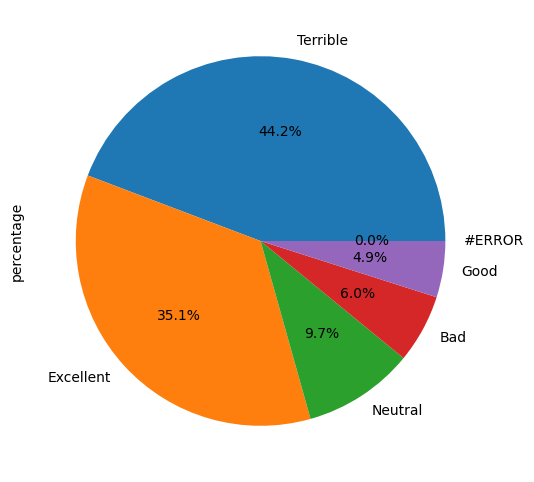

In [17]:
resumen['percentage'].plot.pie(autopct='%1.1f%%', figsize=(6, 6), labels=resumen.index)

In [18]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

<Axes: title={'center': 'Sentiment Analysis over time'}, xlabel='Date', ylabel='Score'>

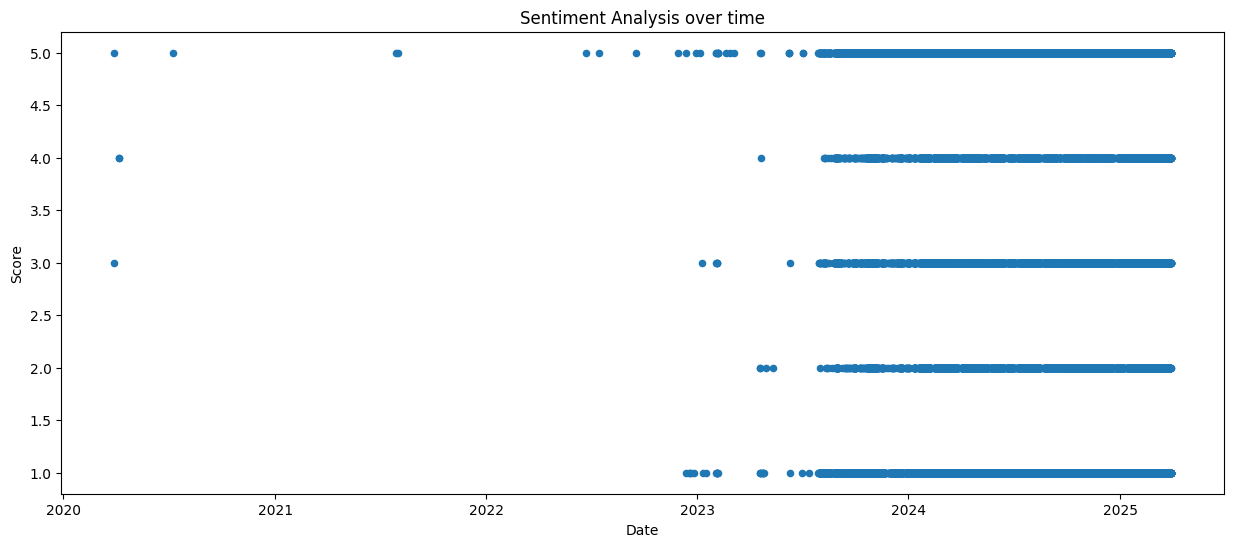

In [19]:
df_sentiment.sort_values(by='date').plot.scatter(x='date', y='score', figsize=(15, 6), title='Sentiment Analysis over time', xlabel='Date', ylabel='Score')

In [20]:
df_sentiment.to_excel(r"results\comments_sentiment_analysis_galan_v2.xlsx", index=False)

In [21]:
# df_sentiment = pd.read_excel(r"results\comments_sentiment_analysis_galan.xlsx")

In [22]:
# df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

In [23]:
df_sorted = df_sentiment.sort_values(by='date')

In [24]:
display(df_sorted.head(20))

,score,clasification,percentage,date,video_id
21832,5.0,Excellent,0.361701,2020-03-28 15:12:00,6809324911199325445
21833,3.0,Neutral,0.287134,2020-03-28 15:20:00,6809324911199325445
31228,4.0,Good,0.280409,2020-04-05 14:27:00,6812310179984461061
31229,4.0,Good,0.257344,2020-04-05 14:28:00,6812310179984461061
5866,5.0,Excellent,0.294739,2020-07-08 15:59:00,6827223821636898054
47699,5.0,Excellent,0.494593,2021-07-28 20:52:00,6989821152516508933
47700,5.0,Excellent,0.308578,2021-07-31 17:28:00,6989821152516508933
41896,5.0,Excellent,0.492396,2022-06-21 19:01:00,7111126678847458566
41895,5.0,Excellent,0.318771,2022-07-14 14:36:00,7111126678847458566
22905,5.0,Excellent,0.308578,2022-09-16 21:07:00,7144163114446097670


In [25]:
def count_ratings_by_month(df):
    # Make sure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.to_period('M')
    
    # Group by month and rate, then count
    result = df.groupby(['month', 'score']).size().unstack(fill_value=0)
    
    # Add a total column
    result['total'] = result.sum(axis=1)

    #Calculate Average
    temp_df = df[['month', 'score']].copy()

    # Group by month and calculate mean
    avg_ratings = temp_df.groupby('month')['score'].mean().round(2)

    result['average_rating'] = avg_ratings
    
    return result

In [26]:
monthly_counts = count_ratings_by_month(df_sorted)

In [27]:
display(monthly_counts)

score,1.0,2.0,3.0,4.0,5.0,total,average_rating
month,,,,,,,
2020-03,0,0,1,0,1,2,4.00
2020-04,0,0,0,2,0,2,4.00
2020-07,0,0,0,0,1,1,5.00
2021-07,0,0,0,0,2,2,5.00
2022-06,0,0,0,0,1,1,5.00
2022-07,0,0,0,0,1,1,5.00
2022-09,0,0,0,0,1,1,5.00
2022-11,0,0,0,0,1,1,5.00
2022-12,5,0,0,0,2,7,2.14


<Axes: title={'center': 'Total Ratings by Month'}, xlabel='Month', ylabel='Total Ratings'>

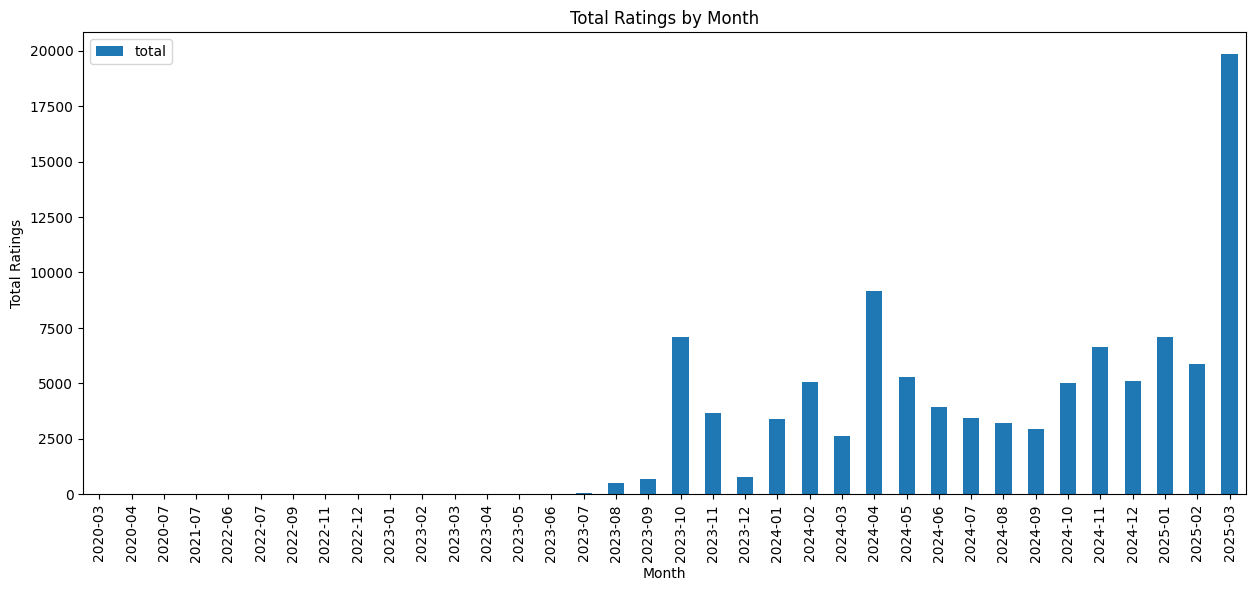

In [28]:
monthly_counts.plot.bar(y='total', figsize=(15, 6), title='Total Ratings by Month', xlabel='Month', ylabel='Total Ratings')

In [29]:

def visualize_rating_percentages(df):
    """
    Create visualizations for rating percentages by month and average rating over time.
    
    Parameters:
    df: DataFrame with index=score_month and columns 1, 2, 3, 4, 5, total, average_rating
    
    Returns:
    None (displays plots)
    """
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Calculate percentages for each rating
    for rating in range(1, 6):
        df_copy[f"{rating}_percent"] = (df_copy[rating] / df_copy['total'] * 100).round(2)
    
    # Get months from index
    months = df_copy.index
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # 1. Stacked bar chart - Rating distribution by month
    x = np.arange(len(months))
    width = 0.8
    
    # Get percentage data for each rating
    rating_percentages = [df_copy[f"{rating}_percent"].values for rating in range(1, 6)]
    
    # Colors for ratings
    colors = ['#FF9999', '#FFD699', '#FFFF99', '#99FF99', '#9999FF']
    
    # Create the stacked bar chart
    bottom = np.zeros(len(months))
    for i, data in enumerate(rating_percentages):
        label = f"{i+1} Star"
        ax1.bar(x, data, width, bottom=bottom, label=label, color=colors[i])
        bottom += data
    
    ax1.set_title('Rating Distribution by Month', fontsize=14)
    ax1.set_ylabel('Percentage (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(months, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.legend(title='Rating')
    
    # 2. Line chart for average rating over time
    ax2.plot(x, df_copy['average_rating'], marker='o', linewidth=2, color='#3366CC')
    
    # Add data labels
    for i, val in enumerate(df_copy['average_rating']):
        ax2.text(i, val + 0.05, f"{val}", ha='center', va='bottom', fontsize=10)
    
    ax2.set_title('Average Rating by Month', fontsize=14)
    ax2.set_ylabel('Average Rating')
    ax2.set_xticks(x)
    ax2.set_xticklabels(months, rotation=45, ha='right')
    ax2.set_ylim(min(df_copy['average_rating'])-0.5, max(df_copy['average_rating'])+0.5)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal line at rating 4.0 for reference
    ax2.axhline(y=4.0, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization - Heatmap of percentage distribution using imshow
    fig, ax = plt.subplots(figsize=(18, 6))
    
    # Prepare heatmap data
    heatmap_data = np.array([df_copy[f"{i}_percent"].values for i in range(1, 6)])
    
    # Create heatmap using imshow
    im = ax.imshow(heatmap_data, cmap='YlGnBu')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Percentage (%)')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(months)))
    ax.set_xticklabels(months, rotation=45, ha='right')
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels([f"{i}★" for i in range(1, 6)])
    
    # Add text annotations to heatmap
    for i in range(5):
        for j in range(len(months)):
            text = ax.text(j, i, f"{heatmap_data[i, j]:.1f}%",
                          ha="center", va="center", color="black")
    
    plt.title('Percentage of Each Rating by Month', fontsize=14)
    plt.tight_layout()
    plt.show()

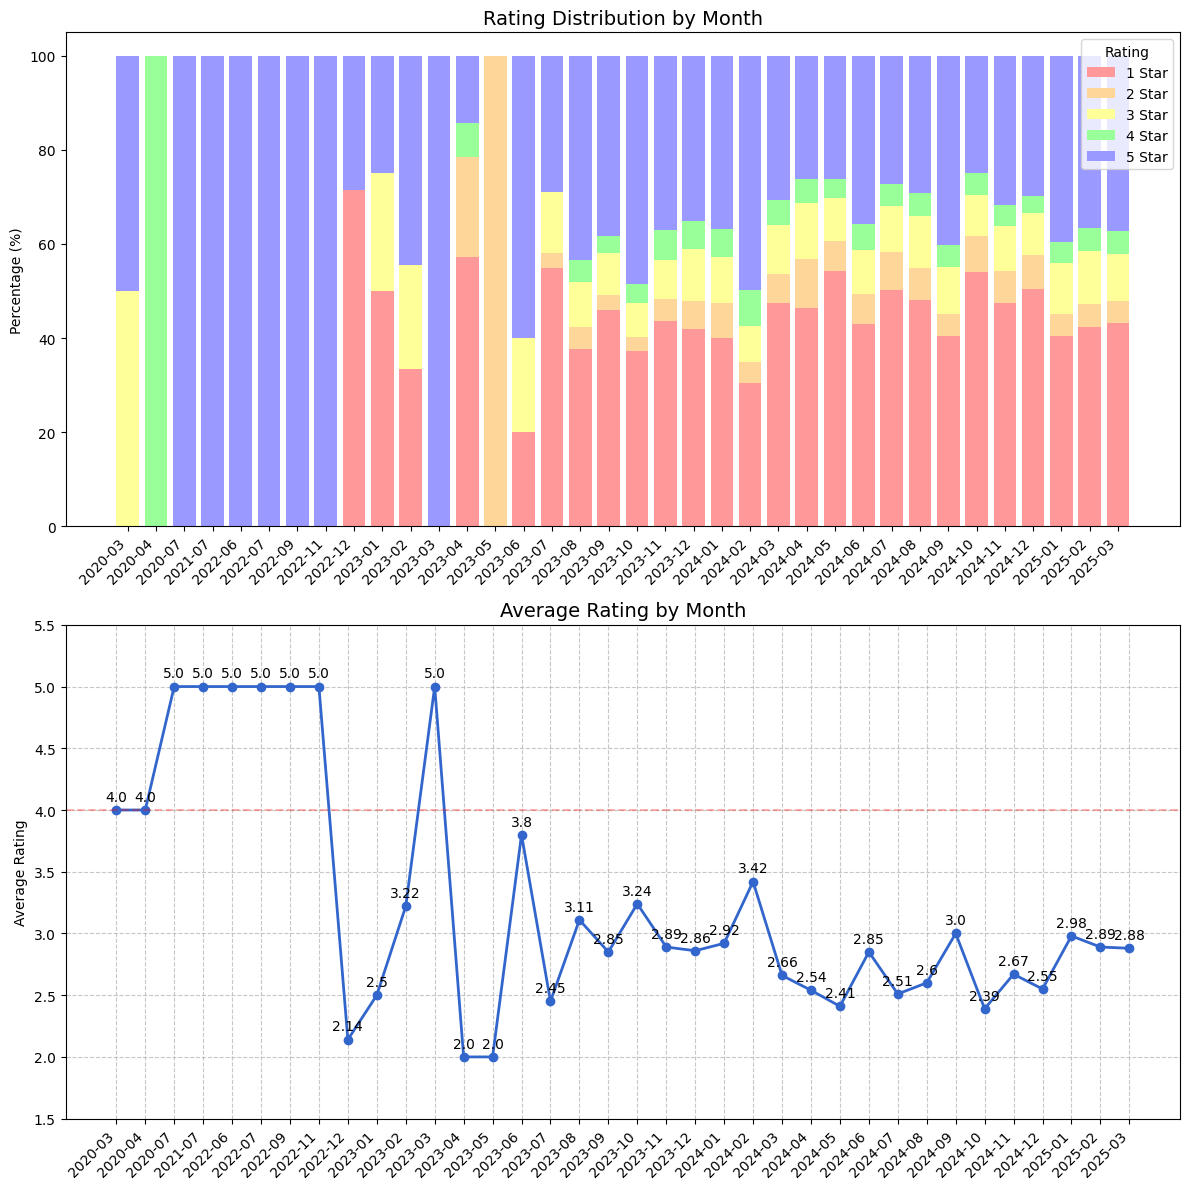

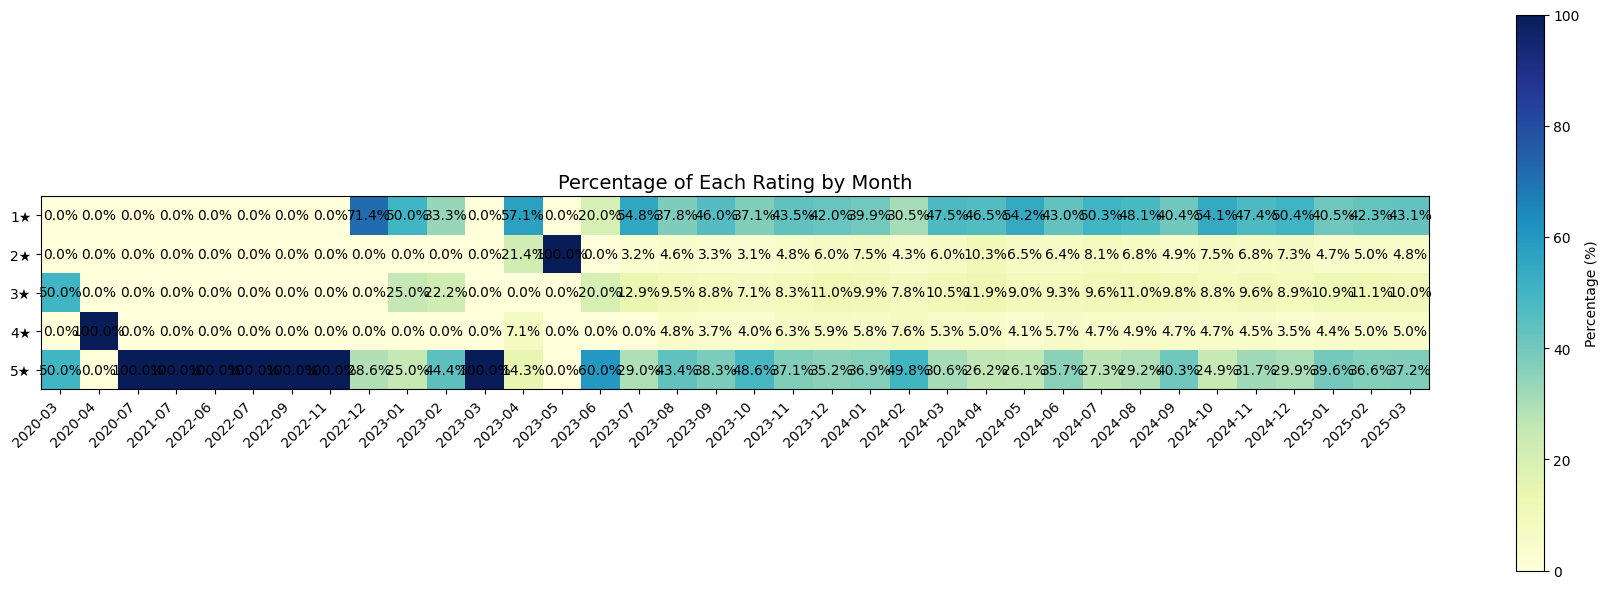

In [30]:
visualize_rating_percentages(monthly_counts)

In [7]:
df_sentiment['Approval'] = df_sentiment['score'].apply(lambda x: 'Approved' if x >= 4 else 'Disapproved' if x <= 2 else 'Neutral')

In [8]:
def approval_by_month(df):
    # Make sure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.to_period('M')
    
    # Group by month and Approval status, then count
    result = df.groupby(['month', 'Approval']).size().unstack(fill_value=0)
    
    # Add a total column
    result['total'] = result.sum(axis=1)

    #Calculate percentages
    for rating in ['Approved', 'Disapproved', 'Neutral']:
        result[f"{rating}_percent"] = (result[rating] / result['total'] * 100).round(2)

    # result['approval_percentages'] = approval_percentages
    
    return result

In [9]:
df_approval = approval_by_month(df_sentiment)

In [34]:
df_approval.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['Approved', 'Disapproved', 'Neutral', 'total', 'Approved_percent',
       'Disapproved_percent', 'Neutral_percent'],
      dtype='object', name='Approval')>

In [35]:
display(df_approval.head(100))

Approval,Approved,Disapproved,Neutral,total,Approved_percent,Disapproved_percent,Neutral_percent
month,,,,,,,
2020-03,1,0,1,2,50.00,0.00,50.00
2020-04,2,0,0,2,100.00,0.00,0.00
2020-07,1,0,0,1,100.00,0.00,0.00
2021-07,2,0,0,2,100.00,0.00,0.00
2022-06,1,0,0,1,100.00,0.00,0.00
2022-07,1,0,0,1,100.00,0.00,0.00
2022-09,1,0,0,1,100.00,0.00,0.00
2022-11,1,0,0,1,100.00,0.00,0.00
2022-12,2,5,0,7,28.57,71.43,0.00


In [11]:
invamer_data = {
    'date': ['2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02'],
    'Approved_percent': [54,56,59,53,47,49,50,51,52,49,47,45,44]
}
df_invamer = pd.DataFrame(invamer_data)

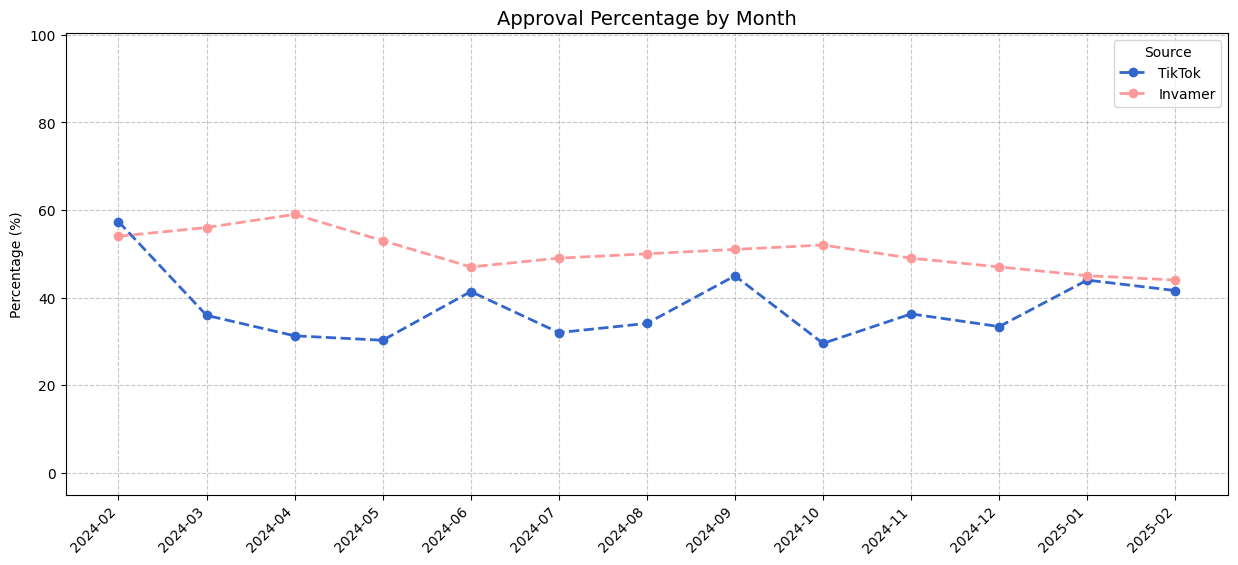

In [37]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

x_data = range(len(invamer_data['date']))

ax1.set_title('Approval Percentage by Month', fontsize=14)
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(x_data)
ax1.set_xticklabels(invamer_data['date'], rotation=45, ha='right')
ax1.set_ylim(min(df_approval['Approved_percent'])-5, max(df_approval['Approved_percent'])+0.5)
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.plot(x_data, df_approval.loc['2024-02':'2025-02']['Approved_percent'], marker='o', linewidth=2, color='#3366CC', linestyle='--')
ax1.plot(x_data, df_invamer['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')

ax1.legend(['TikTok', 'Invamer'], title='Source')


### Smooth curve

In [4]:
df_sentiment = pd.read_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\results\comments_sentiment_analysis_galan_v2.xlsx", sheet_name='Sheet1')
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

In [13]:
df_approval['rolling_avg_aproval'] = df_approval['Approved_percent'].rolling(window=3, center=True).mean()

In [16]:
display(df_approval.head(100))

Approval,Approved,Disapproved,Neutral,total,Approved_percent,Disapproved_percent,Neutral_percent,rolling_avg_aproval
month,,,,,,,,
2020-03,1,0,1,2,50.00,0.00,50.00,NaN
2020-04,2,0,0,2,100.00,0.00,0.00,83.333333
2020-07,1,0,0,1,100.00,0.00,0.00,100.000000
2021-07,2,0,0,2,100.00,0.00,0.00,100.000000
2022-06,1,0,0,1,100.00,0.00,0.00,100.000000
2022-07,1,0,0,1,100.00,0.00,0.00,100.000000
2022-09,1,0,0,1,100.00,0.00,0.00,100.000000
2022-11,1,0,0,1,100.00,0.00,0.00,76.190000
2022-12,2,5,0,7,28.57,71.43,0.00,51.190000


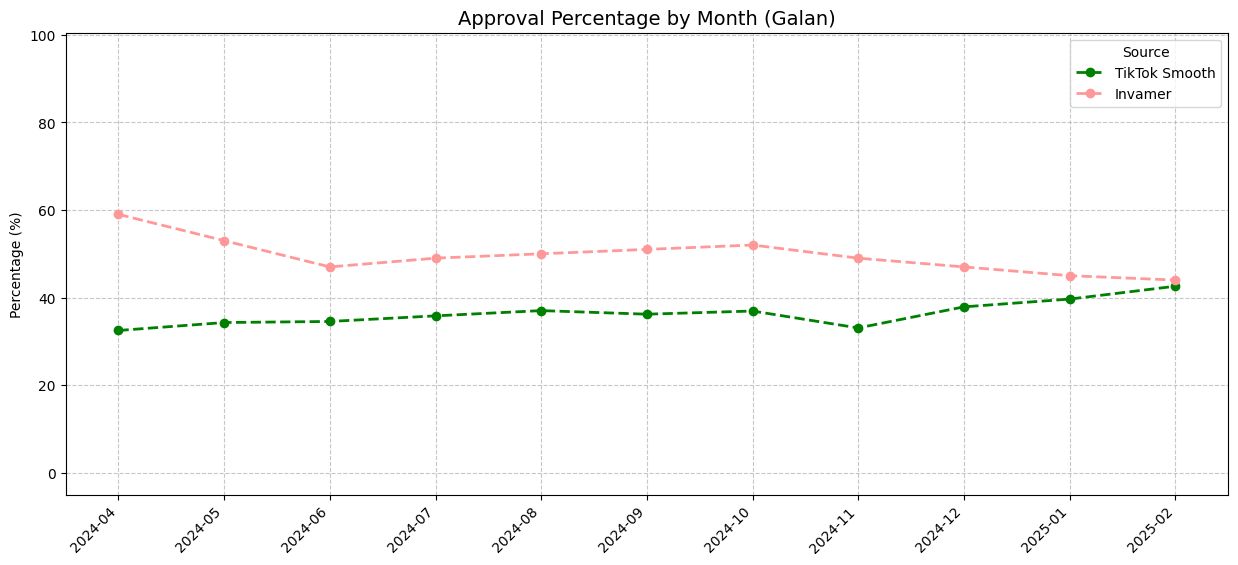

: 

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))


x_values = df_approval.loc['2024-04':'2025-02']['rolling_avg_aproval']
x_data = range(len(x_values))

ax1.set_title('Approval Percentage by Month (Galan)', fontsize=14)
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(x_data)
ax1.set_xticklabels(df_invamer['date'][-11:], rotation=45, ha='right')
ax1.set_ylim(min(df_approval['Approved_percent'])-5, max(df_approval['Approved_percent'])+0.5)
ax1.grid(True, linestyle='--', alpha=0.7)

# ax1.plot(x_data, df_approval.loc['2022-08':'2025-03']['Approved_percent'], marker='o', linewidth=2, color='#3366CC', linestyle='--')
# ax1.plot(x_data, df_approval.loc['2022-08':'2025-03']['rolling_avg_aproval'], marker='o', linewidth=2, color='green', linestyle='--')
# ax1.plot(x_data, df_polls['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')

ax1.plot(x_data, x_values, marker='o', linewidth=2, color='green', linestyle='--')
ax1.plot(x_data, df_invamer.iloc[-11:]['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')

ax1.legend(['TikTok Smooth','Invamer'], title='Source')